# Simple LLM Chain API with LangServe
* Notebook by Adam Lang
* Date: 11/7/2024

# Overview
* This notebook demonstrates how to build a simple LLM chain API application and deploy using LangServe.

# Architecture
* The architecture flow is below:
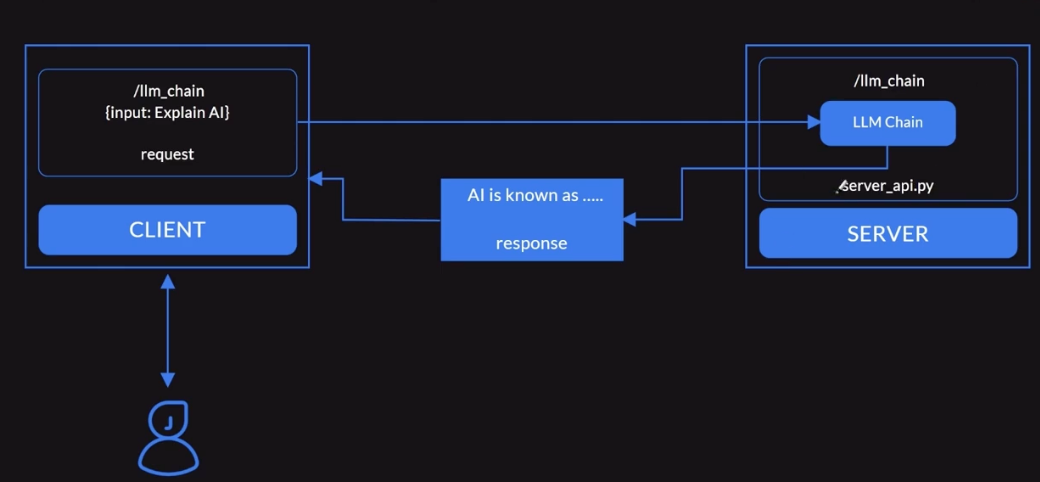

# Install Dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langserve[all]==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.0
    Uninstalling langchain-text-splitters-0.3.0:
      Successfully uninstalled langchain-text-splitters-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━

# Enter Open AI API key


In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


# Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

# CORS (Cross-Origin Resource Sharing)
* Important to use whenever your back-end code has a different origin than the front-end.
* Link to FastAPI docs: https://fastapi.tiangolo.com/tutorial/cors/


In [5]:
## save server API into python file to be deployed
%%writefile langchain_server_api.py
from fastapi import FastAPI
from langchain_openai import ChatOpenAI
from fastapi.middleware.cors import CORSMiddleware
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langserve import add_routes
import os


## create instance of FastAPI to serve as main application (main API)
app = FastAPI(
    title="Langchain Server",
    version="1.0",
    description="Spin up simple API server using LangChain's Runnable interfaces",
)

## Step 1 is to create your application
## Configure CORS middleware to allow all origins, enabling cross-origin requests.
## details are here: https://fastapi.tiangolo.com/tutorial/cors/
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
    expose_headers=["*"],
)

## Building First endpoint in application -- accessible to client
@app.get("/liveness")
def liveness():
    """
    Define a liveness check endpoint.

    This route is used to verify that the API is operational and responding to requests.

    Returns:
        A simple string message indicating the API is working.
    """
    return 'API Works!' ## return string if API is working!


## create input prompt
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI assistant, answer questions in detail with examples as necessary"),
        ("human", "{input}"),

    ]
)

## Initialize the OpenAI Chat instance with specific model parameters.
chatgpt = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

## create simple llm LCEL chain
llm_chain = (prompt
                |
            chatgpt
                |
            StrOutputParser()
)

## Register routes using LangChain's utility function which integrates chat model into API
## call add_routes function
add_routes(
    app,
    llm_chain,
    path="/llm_chain",
)

## main function to start application

if __name__ == "__main__":
    import uvicorn
    # Start up the uvicorn server on localhost port 8989
    uvicorn.run(app, host="127.0.0.1", port=8989)



Writing langchain_server_api.py


Note: We are deploying an async server via uvicorn.
* Uvicorn docs: https://www.uvicorn.org/

## Run and Deploy application
* We will run this in "background mode" as a background process.

In [6]:
!python langchain_server_api.py &>./app_logs.txt &

The code below shows us the file logs
* It verifies the app is now running.

In [7]:
!ps -ef | grep langchain_server_api

root        6469       1  7 15:23 ?        00:00:03 python3 langchain_server_api.py
root        6623     929  0 15:24 ?        00:00:00 /bin/bash -c ps -ef | grep langchain_server_api
root        6625    6623  0 15:24 ?        00:00:00 grep langchain_server_api


In [ ]:
!sudo kill -9 12764

# Load Dependencies
* Now let's simulate that we have a user on the client side.

In [8]:
from langchain_core.prompts import ChatPromptTemplate
import requests

# Check if API works
* We can use python requests library to access API and check functionality.

In [10]:
response = requests.get('http://127.0.0.1:8989/liveness')

In [11]:
response.json(), response.status_code

('API Works!', 200)

Summary:
* Aha! now we can verify the API is working!

# Connect to LLM API Endpoint

In [12]:
from langserve import RemoteRunnable

## endpoint
chain_endpoint = RemoteRunnable("http://127.0.0.1:8989/llm_chain")

## Try simple prompt

In [13]:
prompt = "Tell me about Generative AI in 3 bullet points."

In [14]:
## send prompt to API
response = chain_endpoint.invoke({'input': prompt})

In [15]:
## get response
print(response)

1. Generative AI is a type of artificial intelligence that is capable of creating new content, such as images, text, or music, based on patterns and examples it has been trained on. This is in contrast to other types of AI, such as discriminative AI, which focuses on classification and prediction tasks.

2. One popular application of generative AI is in the field of image generation, where models like Generative Adversarial Networks (GANs) are used to create realistic images from scratch. For example, GANs have been used to generate photorealistic images of non-existent faces, animals, or even landscapes.

3. Generative AI has also been used in natural language processing tasks, such as text generation and language translation. Models like OpenAI's GPT-3 can generate human-like text based on a given prompt, while neural machine translation models like Google Translate use generative techniques to translate text between languages.


# API supports native streaming
* Streaming is supported thanks to LangServe.

In [16]:
## call chain_endpoint.stream --> pass prompt
content = ''
for chunk in chain_endpoint.stream({'input': prompt}):
  print(chunk, end="", flush=True)
  content+=chunk

1. Generative AI is a type of artificial intelligence that is capable of creating new content, such as images, text, or music, based on patterns it has learned from existing data. This is in contrast to other types of AI, such as discriminative AI, which focuses on classification tasks.

2. One popular application of generative AI is in the field of image generation, where models like Generative Adversarial Networks (GANs) are used to create realistic images that do not actually exist. For example, GANs can be used to generate photorealistic images of human faces, animals, or even landscapes.

3. Generative AI has also been used in natural language processing tasks, such as text generation and language translation. Models like OpenAI's GPT-3 can generate coherent and contextually relevant text based on a given prompt, while neural machine translation models like Google Translate use generative techniques to translate text between languages.

In [17]:
## print content
content

"1. Generative AI is a type of artificial intelligence that is capable of creating new content, such as images, text, or music, based on patterns it has learned from existing data. This is in contrast to other types of AI, such as discriminative AI, which focuses on classification tasks.\n\n2. One popular application of generative AI is in the field of image generation, where models like Generative Adversarial Networks (GANs) are used to create realistic images that do not actually exist. For example, GANs can be used to generate photorealistic images of human faces, animals, or even landscapes.\n\n3. Generative AI has also been used in natural language processing tasks, such as text generation and language translation. Models like OpenAI's GPT-3 can generate coherent and contextually relevant text based on a given prompt, while neural machine translation models like Google Translate use generative techniques to translate text between languages."

In [18]:
### Batch execution -- format prompts
qs = ['Tell me about Generative AI in 3 bullet points',
      'Tell me what is a large language model',
      'Explain prompt engineering in 1 line']

# store prompts
prompts = [{'input': q} for q in qs]
prompts

[{'input': 'Tell me about Generative AI in 3 bullet points'},
 {'input': 'Tell me what is a large language model'},
 {'input': 'Explain prompt engineering in 1 line'}]

# Batch Execution

In [19]:
## await send prompts in batches
responses = await chain_endpoint.abatch(prompts)

In [20]:
## get responses
for response in responses:
  print(response)
  print('-----')

1. Generative AI is a type of artificial intelligence that is capable of creating new content, such as images, text, or music, based on patterns it has learned from a dataset. It differs from other AI models that are designed for classification or prediction tasks.

2. One popular application of generative AI is in the field of image generation, where models like Generative Adversarial Networks (GANs) are used to create realistic images that do not actually exist. For example, GANs can be used to generate photorealistic images of human faces, animals, or even landscapes.

3. Generative AI has also been used in natural language processing tasks, such as text generation and language translation. Models like OpenAI's GPT-3 can generate coherent and contextually relevant text based on a given prompt, while neural machine translation models like Google Translate use generative techniques to translate text between languages.
-----
A large language model is a type of artificial intelligence (